In [70]:
import pandas as pd
import numpy as np
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import normalize
from src.functions import get_sents, display_topics
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
import matplotlib.pylab as plt
%matplotlib inline

In [71]:
# Read in the transcripts
raw_data_path = './data/raw/ted-talks/'
transcripts_filename = 'transcripts.csv'
t_df = pd.read_csv(raw_data_path+transcripts_filename)
# Pare down the corpus to only those talks with the word 'love'
love=t_df[t_df['transcript'].str.contains(r'\blove',case=False)]
# Tokenize
# Get the collection of n(=5)-sentence snippets with the word 'love'
love_snippets = get_sents(love,'love',0,0)

From results EDA I found that talk ID=132 and 2382 were 'outliers' after dimension reduction was performed when using CountVectorizer(binary=False).  These two talks were songs that mentioned love a lot.  By deleting them I'm trying to capture orthogonal variance in topics modeling to not be dominated by these 2 talks.

In [72]:
# love_snippets.loc[[132, 2382]]

I'll uncomment this when I want those song talks eliminated.

In [73]:
# love_snippets.drop(labels=[132, 2382],inplace=True)

In [74]:
# Topic modeling
# Vectorize
tfidf1 = TfidfVectorizer(stop_words='english', lowercase=True,binary=True)
doc_words_tfidf1 = tfidf1.fit_transform(love_snippets.love)

# Dimension Reduction
tfidf_lsa=[]
tfidf_doc_topic=[]
for i in range(2,7):
    tfidf_lsa.append(TruncatedSVD(i))
    tfidf_doc_topic.append(tfidf_lsa[i-2].fit_transform(doc_words_tfidf1))
    print(int(i),'topics variance ratios:',tfidf_lsa[i-2].explained_variance_ratio_)

2 topics variance ratios: [0.0038301  0.00841533]
3 topics variance ratios: [0.0038301  0.00841519 0.00523242]
4 topics variance ratios: [0.00383013 0.0084155  0.00523579 0.00395203]
5 topics variance ratios: [0.00383011 0.00841524 0.00523778 0.00390386 0.00381787]
6 topics variance ratios: [0.00383012 0.00841527 0.00523885 0.00394953 0.00381095 0.00361419]


In [75]:
display_topics(tfidf_lsa[0], tfidf1.get_feature_names(), 14)


Topic  0
love, loved, people, know, really, like, laughter, just, things, think, thing, said, ve, make

Topic  1
love, labor, vodka, wires, thirds, complexity, mythology, imagining, phrase, museums, action, okay, air, chocolate


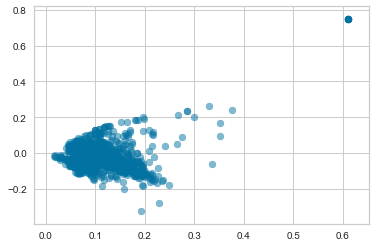

In [76]:
plt.scatter(tfidf_doc_topic[0][:,0],tfidf_doc_topic[0][:,1], alpha = 0.5);
# plt.axis([0, 60, -30, 10])

Investigating the interesting result above seemed  to show that the points in the upper right had longer snippets.  So, I decided to see if there was a relationship with the number of sentences with love in it:

Matplotlib colormaps: https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html

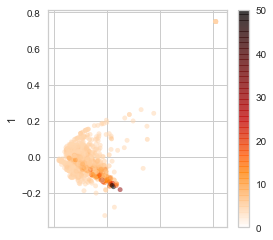

In [77]:
df=pd.DataFrame(tfidf_doc_topic[0])
df.plot.scatter(x=0,y=1,figsize=(4,4), alpha=0.5,\
               c=love_snippets.n_love_sents+3, cmap=plt.get_cmap('gist_heat_r'),vmin=0);

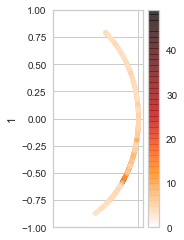

In [78]:
df = pd.DataFrame(normalize(tfidf_doc_topic[0]))
df.plot.scatter(x=0,y=1,figsize=(2,4), alpha=0.5,\
               c=love_snippets.n_love_sents+2, cmap=plt.get_cmap('gist_heat_r'),vmin=0)
plt.axis([0,1.05,-1,1]);
# plt.savefig("reports/figures/figure_1.png")

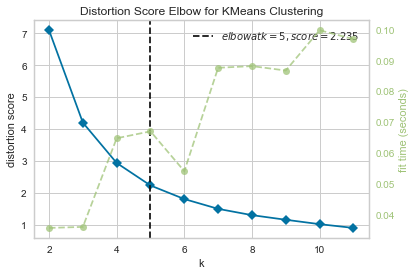

In [79]:
km=KMeans()
visualizer = KElbowVisualizer(km, k=(2,12))
visualizer.fit(tfidf_doc_topic[0])        # Fit the data to the visualizer
visualizer.show();        # Finalize and render the figure

In [80]:
visualizer.elbow_value_

5

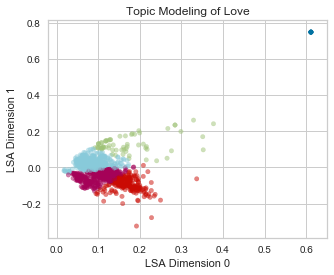

In [81]:
df=pd.DataFrame(tfidf_doc_topic[0],columns=['LSA Dimension 0','LSA Dimension 1'])
num_clusters = visualizer.elbow_value_
km = KMeans(n_clusters=num_clusters,random_state=None,n_init=300,verbose=0) # n_init, number of times the K-mean algorithm will run
km.fit(df)
km.labels_
cmap = {0:'r',1:'g',2:'b',3:'c',4:'m',5:'y',6:'orange',7:'k',8:'aqua',9:'yellow'}
col = pd.DataFrame(np.array([km.labels_])).transpose()[0].map(cmap)
df.plot.scatter(x='LSA Dimension 0',y='LSA Dimension 1',\
                figsize=(5,4), c=col, alpha = 0.5,title='Topic Modeling of Love');
# plt.axis([-1,1.05,-1,1]);

In [82]:
for i,center in enumerate(km.cluster_centers_):
    print(cmap[i],center)

r [ 0.16951486 -0.09505507]
g [0.17111114 0.128845  ]
b [0.61122757 0.74790296]
c [0.08944249 0.02030267]
m [ 0.10422263 -0.04822016]


Getting the matrix of euclidean distances from the cluster centers: (used to work that out)

In [83]:
pd.DataFrame(pairwise_distances(km.cluster_centers_,tfidf_doc_topic[0]).T).head()

,0,1,2,3,4
0,0.043853,0.182331,0.920590,0.099813,0.053222
1,0.098308,0.128089,0.875128,0.066738,0.070405
2,0.163087,0.089072,0.848532,0.046836,0.107814
3,0.045212,0.209482,0.955157,0.104106,0.037010
4,0.057098,0.266057,0.968607,0.196638,0.137156


Show the snippets from the 4 (euclidean distance) closest documents:

In [84]:
doc_topic = tfidf_doc_topic[0]
euclidean_distances_to_centers=pd.DataFrame(pairwise_distances(km.cluster_centers_,doc_topic).T)
for i,center in enumerate(km.cluster_centers_):
    n_closest=euclidean_distances_to_centers[i].nsmallest(4)
    print('Cluster centered at:',center,'color=',cmap[i])
    for j,cs in n_closest.iteritems():
#         print(j,cs)
        print(j,':',doc_topic[j],love_snippets.iloc[j].love)
    print('\n')

Cluster centered at: [ 0.16951486 -0.09505507] color= r
62 : [ 0.16918604 -0.09525674] We can't help but love complexity. We're human beings: we love complex things. We love relationships — very complex. So we love this kind of stuff.I'm at this place called the Media Lab. So, I loved going to school. I love Paola. It's sort of a Midwest cornfield out of french fries.And also, as a child, I was the fattest kid in class, so I used to love Cheetos. Oh, I love Cheetos, yummy. I love life. I love being alive. And so life is a big question, I think, in simplicity, because you're trying to simplify your life.And I just love to see the world. I love these eighty-year-old, ninety-year-old guys and women.
655 : [ 0.16951723 -0.0985302 ] Although my family constantly struggled against poverty, I was always loved and cared for first, because I was the only son and the youngest of two in the family.But then the great famine began in 1994. My foster father's small act of love reminded me of my fath

I'll now project the doc_topic values onto the unit circle, sphere, hypersphere I.  If I don't re-cluster yet, I'm looking at the clustering results from above:

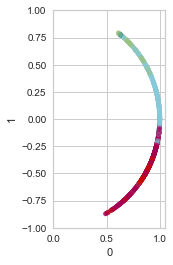

In [85]:
df = pd.DataFrame(normalize(doc_topic))
df.plot.scatter(x=0,y=1,figsize=(2,4), c=col, alpha = 0.5);
plt.axis([0,1.05,-1,1]);
# plt.savefig("reports/figures/figure_1.png")

This next cell identifies the documents closest to the cluster centers using cosine similarity.

In [86]:
for i,center in enumerate(km.cluster_centers_):
    n_closest=pd.DataFrame(cosine_similarity(X=[center],Y=doc_topic).T)[0].nlargest(4)
    print('Cluster centered at:',center,'color=',cmap[i])
    for j,item in n_closest.iteritems():
        print(j,':',doc_topic[j],love_snippets.iloc[j].love)
    print('\n')

Cluster centered at: [ 0.16951486 -0.09505507] color= r
960 : [ 0.21449778 -0.12014087] It was more like, "Look, I've been working on this for half a year, I'd love to have comments. And even before they started giving code back, that was, I think, one of the big moments where I said, "I love other people!" (Laughter)I don't really love other people —(Laughter)But I love computers, I love interacting with other people on email, because it kind of gives you that buffer. But I do love other people who comment and get involved in my project. But you can, actually, you can find things that — you don't even agree to disagree, it's just that you're interested in really different things.And coming back to the point where I said earlier that I was afraid of commercial people taking advantage of your work, it turned out, and very quickly turned out, that those commercial people were lovely, lovely people. And people love Tesla.
612 : [ 0.22764677 -0.12740339] (Laughter) And this young man, his 

Now clustering on the 

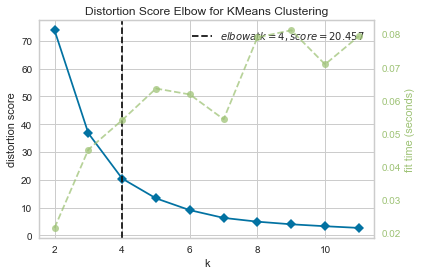

In [87]:
km=KMeans()
visualizer = KElbowVisualizer(km, k=(2,12))
visualizer.fit(df)        # Fit the data to the visualizer
visualizer.show();                     # Finalize and render the figure

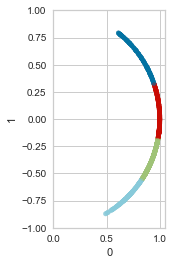

In [88]:
df = pd.DataFrame(normalize(doc_topic))
num_clusters = visualizer.elbow_value_
km = KMeans(n_clusters=num_clusters,random_state=10,n_init=300,verbose=0) # n_init, number of times the K-mean algorithm will run
km.fit(df)
km.labels_
cmap = {0:'r',1:'g',2:'b',3:'c',4:'m',5:'y',6:'orange',7:'k',8:'aqua',9:'yellow'}
col = pd.DataFrame(np.array([km.labels_])).transpose()[0].map(cmap)
df.plot.scatter(x=0,y=1,figsize=(2,4), c=col, alpha = 0.5);
plt.axis([0,1.05,-1,1]);
# plt.savefig("reports/figures/figure_1.png")

In [89]:
for i,center in enumerate(km.cluster_centers_):
    n_closest=pd.DataFrame(cosine_similarity(X=[center],Y=normalize(doc_topic)).T)[0].nlargest(4)
    print('Cluster centered at:',center,'color=',cmap[i])
    for j,item in n_closest.iteritems():
        print(j,':',normalize(doc_topic)[j],love_snippets.iloc[j].love)
    print('\n')

Cluster centered at: [0.98943915 0.0357679 ] color= r
606 : [0.99933864 0.03636314] I love studying these moments in American history when there was this frenzy of partisan anger, that the economy was on the verge of total collapse.The most famous early battle was Alexander Hamilton and Thomas Jefferson over what the dollar would be and how it would be backed up, with Alexander Hamilton saying, "We need a central bank, the First Bank of the United States, or else the dollar will have no value.
43 : [0.99938583 0.03504233] So we use the tools of commerce primarily for our work, but the question we bring to it is, how do we love all the children of all species for all time?
436 : [0.99940175 0.03458528] I love the Internet. It's actually very basic stuff — thinking about continuity, thinking about backups, thinking about the things that actually matter.Now I told you — (Laughter) I love the Internet.
327 : [0.99941414 0.03422529] So I work in marketing, which I love, but my first passion

# The 3-topic Result

In [90]:
display_topics(tfidf_lsa[1], tfidf1.get_feature_names(), 14)


Topic  0
love, loved, people, know, really, like, laughter, just, things, think, thing, said, ve, make

Topic  1
love, labor, wires, vodka, thirds, complexity, mythology, imagining, phrase, museums, action, okay, air, company

Topic  2
loved, really, love, ones, family, concert, told, cook, iphone, detached, sailing, sausages, big, lost


In [91]:
tfidf_doc_topic[1]

array([[ 1.57232003e-01, -5.31474609e-02,  4.94305217e-02],
       [ 1.53609164e-01,  1.15354394e-03, -3.84162104e-02],
       [ 1.15889211e-01,  5.89815871e-02, -5.31475348e-03],
       ...,
       [ 1.05270853e-01,  5.82414363e-02, -7.82519873e-03],
       [ 9.73960180e-02, -3.35900025e-03, -4.46163406e-02],
       [ 1.22532410e-01,  5.19834659e-02, -4.92215487e-05]])

In [92]:
from mpl_toolkits.mplot3d import Axes3D

In [93]:
# Use this to visualize the un-projected doc-topic space:
# df = pd.DataFrame(cv_doc_topic[1])
# Use this to visualize the projected doc-topic space:
df = pd.DataFrame(normalize(tfidf_doc_topic[1]))

Helpful in getting started with 3D plotting:
* https://pythonprogramming.net/3d-graphing-pandas-matplotlib/
* https://matplotlib.org/3.1.1/gallery/mplot3d/scatter3d.html#sphx-glr-gallery-mplot3d-scatter3d-py
* https://stackoverflow.com/questions/47311632/jupyter-how-to-rotate-3d-graph

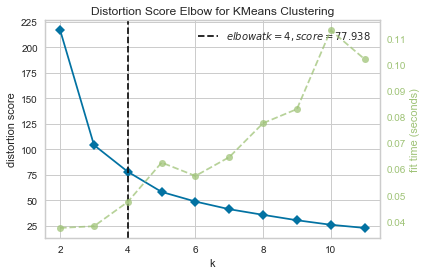

In [94]:
%matplotlib inline
km=KMeans()
visualizer = KElbowVisualizer(km, k=(2,12))
visualizer.fit(df)                     # Fit the data to the visualizer
visualizer.show();                     # Finalize and render the figure

In [98]:
num_clusters = 9 #visualizer.elbow_value_
km = KMeans(n_clusters=num_clusters,random_state=10,n_init=300,verbose=0) # n_init, number of times the K-mean algorithm will run
km.fit(df)
col = pd.DataFrame(np.array([km.labels_])).transpose()[0].map(cmap)

<IPython.core.display.Javascript object>


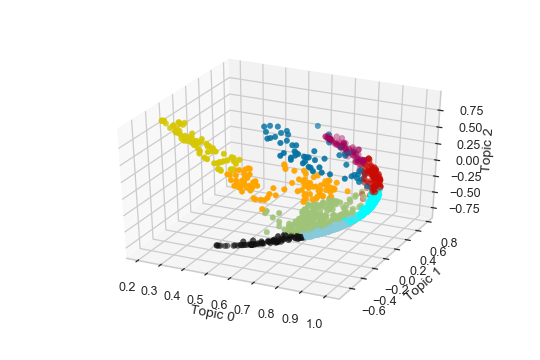

In [99]:
%matplotlib notebook
fig = plt.figure() #.gca(projection='3d')
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df[0],df[1],df[2],c=col)
ax.set_xlabel('Topic 0')
ax.set_ylabel('Topic 1')
ax.set_zlabel('Topic 2')
fig.show();

So, what do the clusters mean?

In [32]:
doc_topic = tfidf_doc_topic[1]
for i,center in enumerate(km.cluster_centers_):
    n_closest=pd.DataFrame(cosine_similarity(X=[center],Y=normalize(doc_topic)).T)[0].nlargest(4)
    print('Cluster centered at:',center,'color=',cmap[i])
    for j,item in n_closest.iteritems():
        print(j,':',normalize(doc_topic)[j],love_snippets.iloc[j].love)
    print('\n')

Cluster centered at: [ 0.90254817 -0.33155774  0.16782413] color= r
1027 : [ 0.92388083 -0.34076914  0.17412811] I love what I do, but I love my kids more. "(Laughter)So my activation button for gay equality was pressed, and along with many, many others, I campaigned for years for gay rights, and in particular, the right to marry the person that I love. And in 2014, on the day that the law was changed, I married my wife, who I love very much, indeed. Love triumphs. I love to gather inspirational stories from the past and pass them on.
379 : [ 0.92307831 -0.3498875   0.15970342] Gather my beloved near, and our chanting will be dancing. One woman no longer believes love will ever find her.
823 : [ 0.92311667 -0.3522621   0.1541656 ] So now, we love cooperation. Now, that's all well done, so we got that from evolution, from maternal care, parental love, but we need to extend that. It shows without ambiguity that there is structural change and functional change in the brain when you train 